In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../src/data/marketing_campaign_cleaned.csv', index_col=[0])
df = data[['Is_Parent', 'MntWines',	'MntFruits',	'MntMeatProducts',	'MntFishProducts',	'MntSweetProducts',	'MntGoldProds',	'NumDealsPurchases',	'NumWebPurchases',	'NumCatalogPurchases',	'NumStorePurchases',	'NumWebVisitsMonth']]
df.head()

,Is_Parent,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,0,635,88,546,172,88,88,3,8,10,4,7
1,1,11,1,6,2,1,6,2,1,1,2,5
2,0,426,49,127,111,21,42,1,8,2,10,4
3,1,11,4,20,10,3,5,2,2,0,4,6
4,1,173,43,118,46,27,15,5,5,3,6,5


<AxesSubplot:>

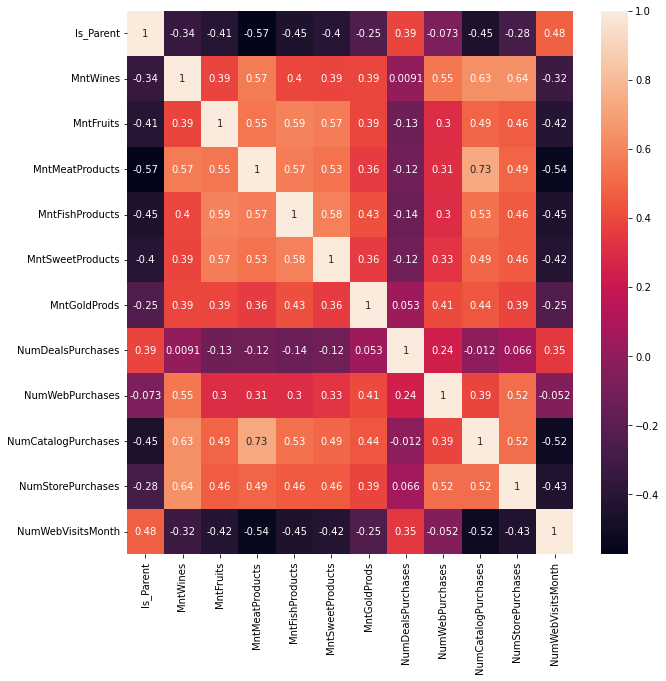

In [3]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True)

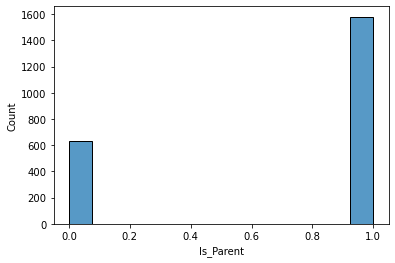

In [18]:
sns.histplot(df['Is_Parent']);

In [5]:
def annotate_corr(x, y, ax=None, **kwargs):
  r, _ = st.pearsonr(x, y)
  ax = ax or plt.gca()
  
  if r > 0:
    fontsizes = {
      range(21): "medium",
      range(21, 51): 'large',
      range(51, 81): 'x-large',
      range(90, 101): 'xx-large',
    }

    font_size = [fontsize for bound,fontsize in fontsizes.items() if round(abs(r), 1) * 100 in bound][0]
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes, fontsize = font_size)

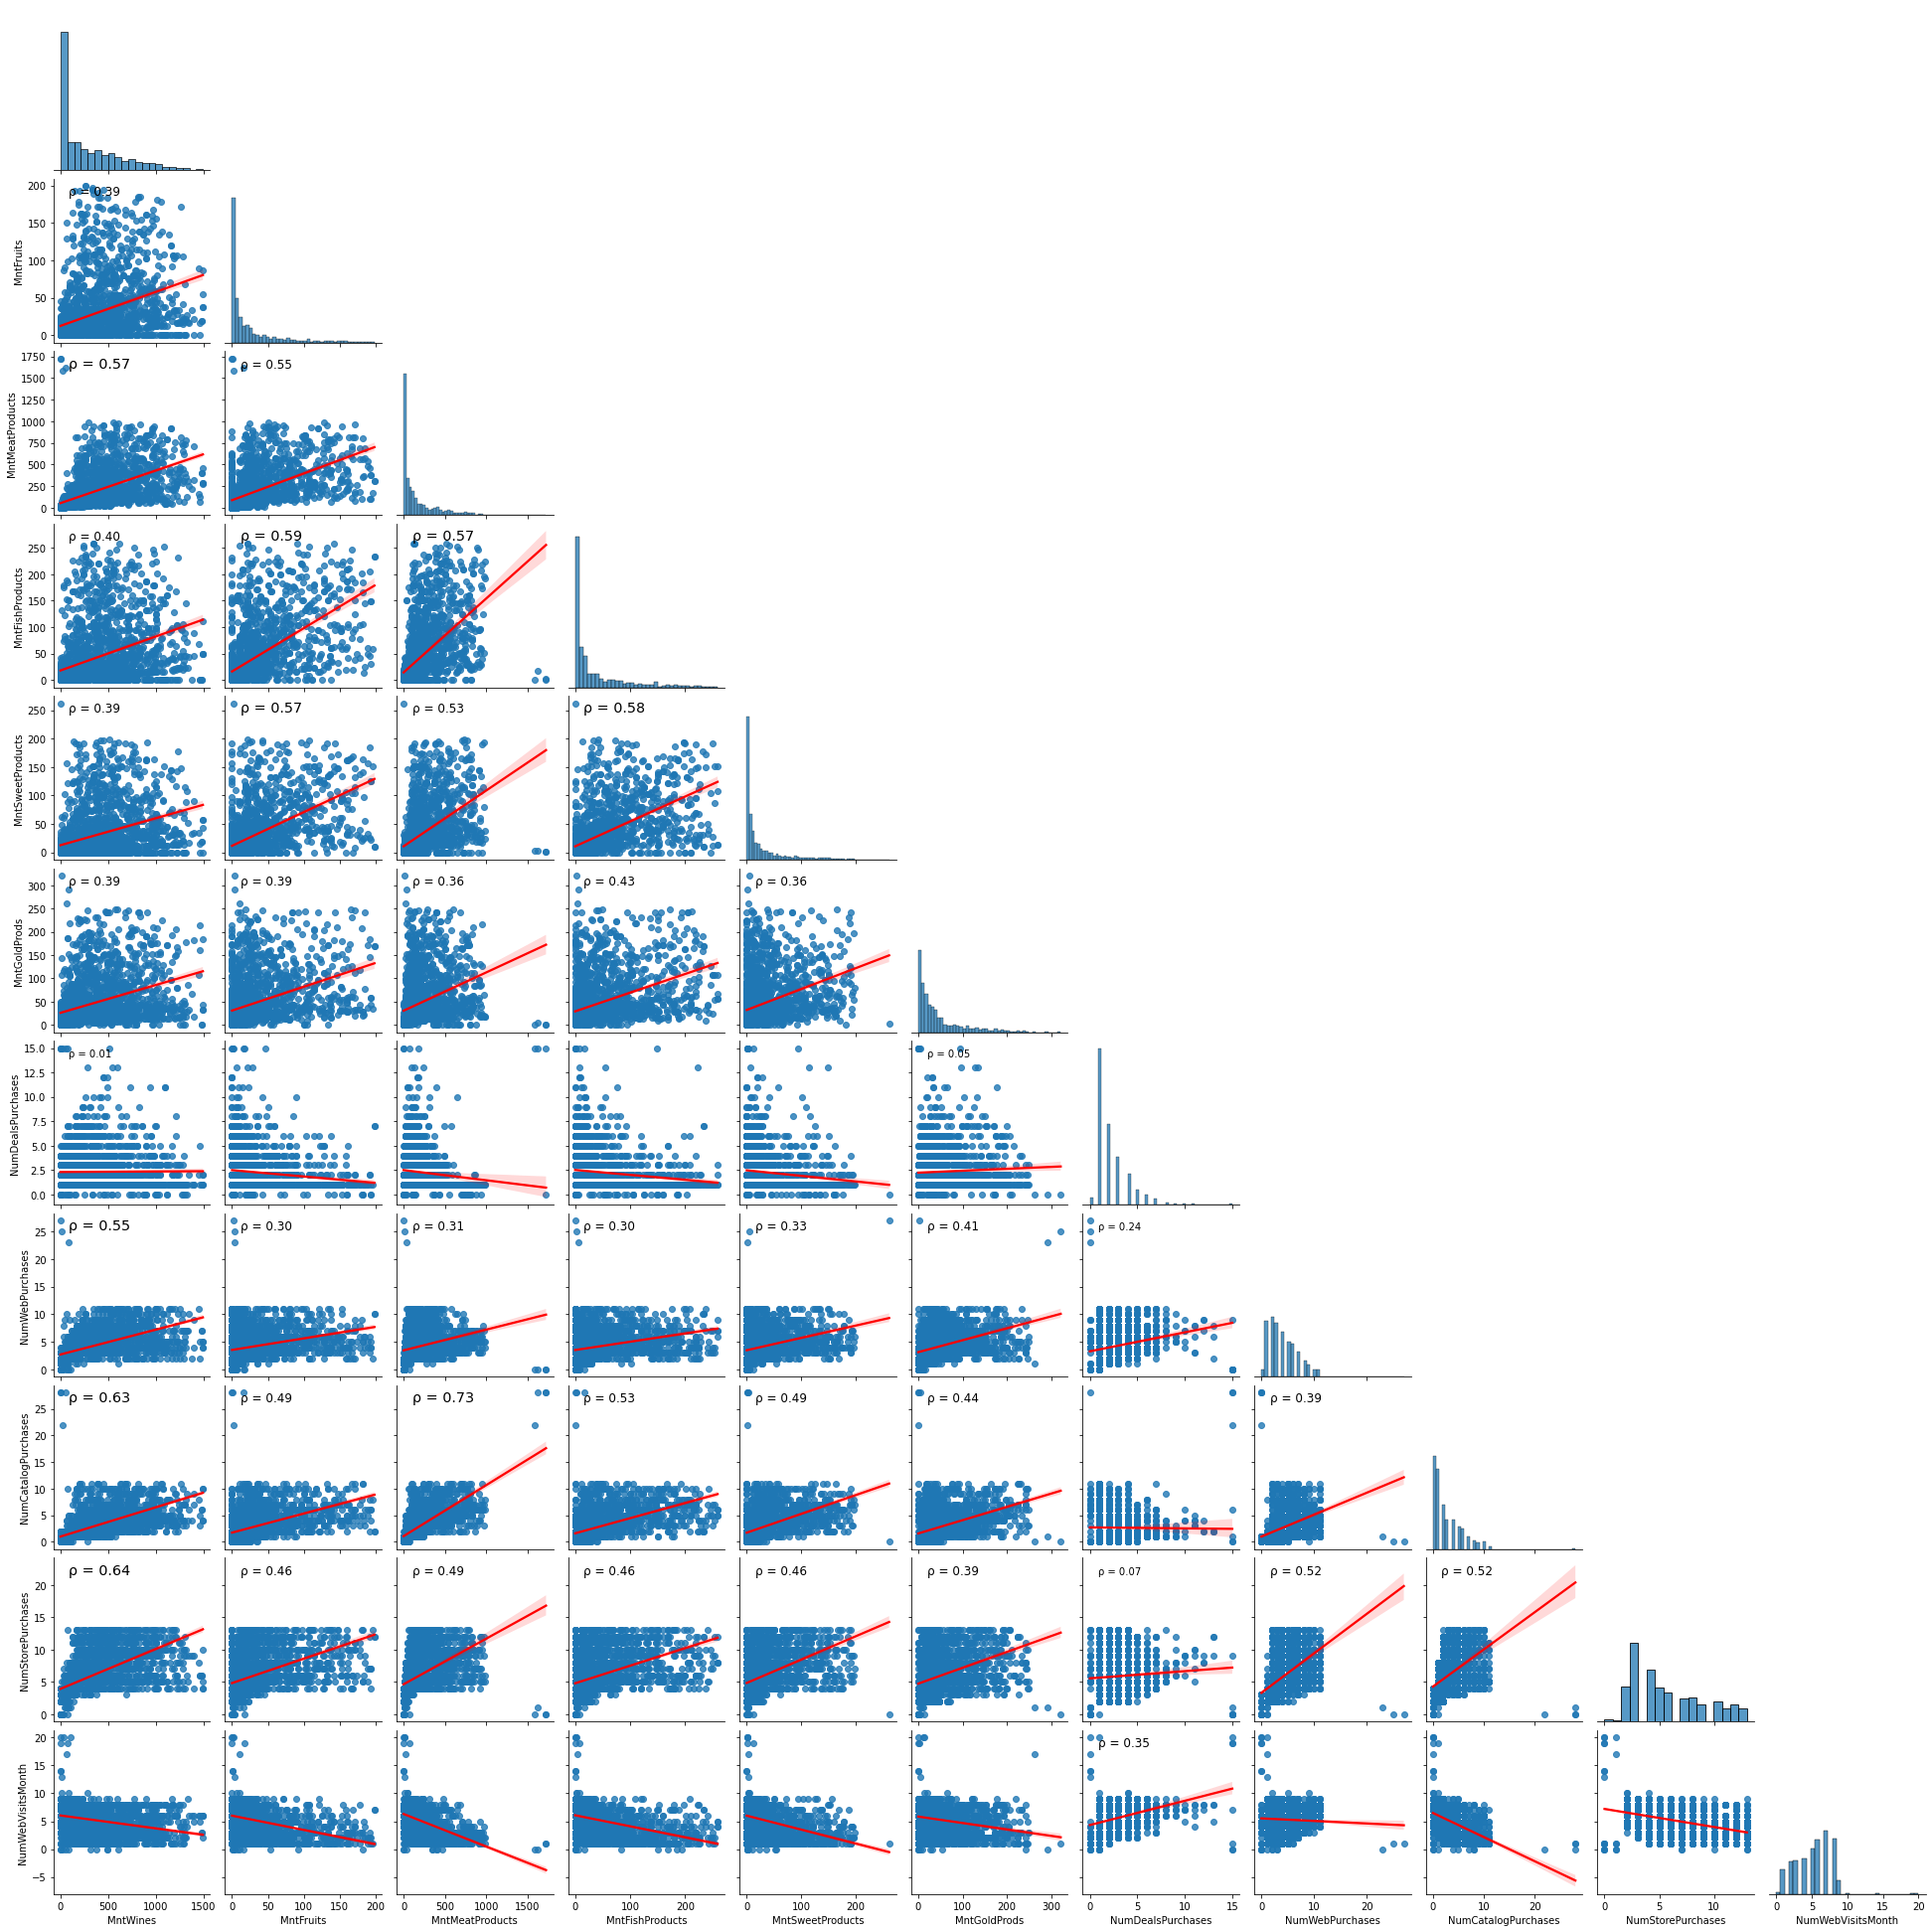

In [6]:
plot = sns.pairplot(df.drop(columns= 'Is_Parent'), kind='reg', corner=True, plot_kws={'line_kws': {'color': 'red'}})
plot.map_lower(annotate_corr)

### Is being a parent correlated to the ammount of spendings on all product categories?

Random component - the distribution of Y (is parent) is binomial
Systematic component: Xs (amount of products bought per category) are explanatory variables
Link function $η = log(\frac{\pi}{1-\pi})$

I will be using logisic regression to model how being a parent is affected by amount of products bought with $\alpha$ = 0.05. Also, I will use backward elimination for feature selection to produce the most accurate model

$H_0$ - the slope of regression line is 0 <br />
$H_1$ - the slope isn't 0 and the response is correlated to the predictor

#### Implemeting the model

In [7]:
alpha = 0.05

In [8]:
y = df['Is_Parent']
x = sm.add_constant(df.iloc[:,1:])

model = sm.GLM(y, x, family=sm.families.Binomial(link=sm.genmod.families.links.logit()))
# sm.Logit(y, x) -> yields the same results
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Is_Parent   No. Observations:                 2212
Model:                            GLM   Df Residuals:                     2200
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -683.88
Date:                Wed, 01 Dec 2021   Deviance:                       1367.8
Time:                        13:29:14   Pearson chi2:                 4.63e+08
No. Iterations:                     8   Pseudo R-squ. (CS):             0.4391
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1180      0.274     -0.430      0.667      -0.655       0.419
MntWines                0.0001      0.000      0.369      0.712      -0.001       0.001
MntFruits              -0.0030      0.002     -1.296      0.195      -0.008       0.002
MntMeatProducts        -0.0054      0.001     -8.168      0.000      -0.007      -0.004
MntFishProducts        -0.0029      0.002     -1.614      0.107      -0.006       0.001
MntSweetProducts       -0.0018      0.002     -0.816      0.415      -0.006       0.003
MntGoldProds           -0.0027      0.002     -1.702      0.089      -0.006       0.000
NumDealsPurchases       1.2630      0.100     12.650      0.000       1.067       1.459
NumWebPurchases         0.0975      0.034      2.884      0.004       0.031       0.164
NumCatalogPurchases    -0.1097      0.043     -2.560      0.010      -0.194      -0.026
NumStorePurchases      -0.0079      0.030     -0.262      0.793      -0.067       0.051
NumWebVisitsMonth       0.0353      0.036      0.992      0.321      -0.034       0.105
=======================================================================================
"""

In [9]:
res.pvalues[1:].loc[lambda x: x <= alpha]

MntMeatProducts        3.129297e-16
NumDealsPurchases      1.113775e-36
NumWebPurchases        3.922415e-03
NumCatalogPurchases    1.045373e-02
dtype: float64

In [10]:
res.pvalues[1:].loc[lambda x: x > alpha]

MntWines             0.712170
MntFruits            0.194971
MntFishProducts      0.106522
MntSweetProducts     0.414500
MntGoldProds         0.088690
NumStorePurchases    0.793157
NumWebVisitsMonth    0.321279
dtype: float64

In [21]:
res.aic

1391.7645038380315

### 1st iteration of backward elimination

In [24]:
res.pvalues.sort_values(ascending=False)

NumStorePurchases      7.931570e-01
MntWines               7.121698e-01
const                  6.668785e-01
MntSweetProducts       4.145001e-01
NumWebVisitsMonth      3.212787e-01
MntFruits              1.949714e-01
MntFishProducts        1.065222e-01
MntGoldProds           8.868981e-02
NumCatalogPurchases    1.045373e-02
NumWebPurchases        3.922415e-03
MntMeatProducts        3.129297e-16
NumDealsPurchases      1.113775e-36
dtype: float64

In [36]:
y = df['Is_Parent']
x = sm.add_constant(df.drop(columns=['Is_Parent', 'NumStorePurchases', 'MntWines']))

model = sm.GLM(y, x, family=sm.families.Binomial(sm.genmod.families.links.logit()))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Is_Parent   No. Observations:                 2212
Model:                            GLM   Df Residuals:                     2202
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -683.97
Date:                Wed, 01 Dec 2021   Deviance:                       1367.9
Time:                        13:53:24   Pearson chi2:                 4.38e+08
No. Iterations:                     8   Pseudo R-squ. (CS):             0.4391
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1541      0.244     -0.632      0.527      -0.632       0.324
MntFruits              -0.0032      0.002     -1.370      0.171      -0.008       0.001
MntMeatProducts        -0.0054      0.001     -8.572      0.000      -0.007      -0.004
MntFishProducts        -0.0029      0.002     -1.675      0.094      -0.006       0.000
MntSweetProducts       -0.0019      0.002     -0.846      0.398      -0.006       0.002
MntGoldProds           -0.0028      0.002     -1.714      0.087      -0.006       0.000
NumDealsPurchases       1.2577      0.098     12.800      0.000       1.065       1.450
NumWebPurchases         0.0990      0.032      3.131      0.002       0.037       0.161
NumCatalogPurchases    -0.1048      0.039     -2.679      0.007      -0.181      -0.028
NumWebVisitsMonth       0.0384      0.034      1.125      0.261      -0.028       0.105
=======================================================================================
"""

In [37]:
res.aic

1387.930431989727

### 2nd iteration of backward elimination

In [38]:
res.pvalues.sort_values(ascending=False)

const                  5.274034e-01
MntSweetProducts       3.976210e-01
NumWebVisitsMonth      2.607981e-01
MntFruits              1.707416e-01
MntFishProducts        9.398202e-02
MntGoldProds           8.657957e-02
NumCatalogPurchases    7.383798e-03
NumWebPurchases        1.740011e-03
MntMeatProducts        1.014390e-17
NumDealsPurchases      1.632780e-37
dtype: float64

In [39]:
y = df['Is_Parent']
x = sm.add_constant(df.drop(columns=['Is_Parent', 'NumStorePurchases', 'MntWines', 'MntSweetProducts', 'NumWebVisitsMonth']))

model = sm.GLM(y, x, family=sm.families.Binomial(sm.genmod.families.links.logit()))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Is_Parent   No. Observations:                 2212
Model:                            GLM   Df Residuals:                     2204
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -685.04
Date:                Wed, 01 Dec 2021   Deviance:                       1370.1
Time:                        13:53:39   Pearson chi2:                 3.56e+08
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4385
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0476      0.163      0.292      0.770      -0.271       0.366
MntFruits              -0.0038      0.002     -1.713      0.087      -0.008       0.001
MntMeatProducts        -0.0056      0.001     -9.011      0.000      -0.007      -0.004
MntFishProducts        -0.0035      0.002     -2.045      0.041      -0.007      -0.000
MntGoldProds           -0.0029      0.002     -1.767      0.077      -0.006       0.000
NumDealsPurchases       1.2811      0.097     13.147      0.000       1.090       1.472
NumWebPurchases         0.1003      0.032      3.162      0.002       0.038       0.162
NumCatalogPurchases    -0.1171      0.038     -3.073      0.002      -0.192      -0.042
=======================================================================================
"""

In [40]:
res.aic

1386.0757557624536

### 3rd iteration of backward elimination

In [41]:
res.pvalues.sort_values(ascending=False)

const                  7.699802e-01
MntFruits              8.668205e-02
MntGoldProds           7.716459e-02
MntFishProducts        4.085954e-02
NumCatalogPurchases    2.117186e-03
NumWebPurchases        1.569316e-03
MntMeatProducts        2.037483e-19
NumDealsPurchases      1.782158e-39
dtype: float64

In [42]:
y = df['Is_Parent']
x = sm.add_constant(df.drop(columns=['Is_Parent', 'NumStorePurchases', 'MntWines', 'MntSweetProducts', 'NumWebVisitsMonth', 'MntFruits']))

model = sm.GLM(y, x, family=sm.families.Binomial(sm.genmod.families.links.logit()))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Is_Parent   No. Observations:                 2212
Model:                            GLM   Df Residuals:                     2205
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -686.52
Date:                Wed, 01 Dec 2021   Deviance:                       1373.0
Time:                        13:54:14   Pearson chi2:                 3.86e+08
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4378
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0385      0.162      0.237      0.812      -0.280       0.357
MntMeatProducts        -0.0058      0.001     -9.526      0.000      -0.007      -0.005
MntFishProducts        -0.0043      0.002     -2.668      0.008      -0.008      -0.001
MntGoldProds           -0.0031      0.002     -1.950      0.051      -0.006    1.61e-05
NumDealsPurchases       1.2859      0.097     13.223      0.000       1.095       1.476
NumWebPurchases         0.0954      0.031      3.063      0.002       0.034       0.157
NumCatalogPurchases    -0.1209      0.038     -3.189      0.001      -0.195      -0.047
=======================================================================================
"""

In [46]:
res.pvalues[1:].loc[lambda x: x <= alpha]

MntMeatProducts        1.631036e-21
MntFishProducts        7.631508e-03
NumDealsPurchases      6.480010e-40
NumWebPurchases        2.192220e-03
NumCatalogPurchases    1.425797e-03
dtype: float64

In [47]:
res.pvalues[1:].loc[lambda x: x > alpha]

MntGoldProds    0.051186
dtype: float64

In [45]:
res.aic

1387.038236339425

## Conclusions
The last model showed that amount spent on meat, fish, deals products and web and catalog purchases has a highly significant p-value. Hence there is a strong relationship between those and being a parent

In [7]:
import plotly.graph_objects as go

In [12]:
x = [0, 1, 2, 3, 4]
y = [1390, 1367, 1264, 1143, 1289]

In [11]:
fig = go.Figure(
  data = go.Scatter(x=x, y=y)
)
fig.show()